## Setup

In [ ]:
dir = dirname(pwd()) * "/PROJECT"
include(dir * "/functions/Preamble.jl")
@everywhere dir = dirname(pwd()) * "/PROJECT"

t0 = now()

In [5]:
@everywhere global const sixVertex::Bool = true
@everywhere global const twoFlip::Bool = false
@everywhere global const δE::Int = sixVertex ? 8 : 4

Lx  Ly  nT    t     t_th
50  50  50  50000  10000
25  25  25  10000   2500

## Data Structure


In [8]:
@everywhere include(dir * "/functions/DataStructure.jl")
@everywhere include(dir * "/functions/Plotting.jl")
@everywhere include(dir * "/functions/Statistics.jl")
@everywhere include(dir * "/functions/Simulation.jl")

## Thermal Conductivity

## Thermal Bath Method


In [ ]:
@everywhere include(dir * "/functions/simulationFunctions/DemonHeatBath.jl")

In [31]:
L = [25, 25]
PBC = [false, true]
Basis = CubicBasis(length(L))

num_histories = 1
therm_runtime = 100
runtime = 500
t_therm = 100
t_autocorr = 1
N_blocks = -1

W = 5
Tc = 0.1 * (sixVertex ? 1.0 : 0.5)
Th = 10.0 * (sixVertex ? 1.0 : 0.5)

T, κ, C, TStd, κStd, CStd = BathSimulation(L, PBC, Basis, W, Tc, Th, num_histories, therm_runtime, runtime, t_therm, t_autocorr, N_blocks);

idx = W+1:size(T, 2)-W+1;

In [32]:
# FUDGE FACTOR - WHYYY MISSING FACTOR 1/2????
κ[1,:,:] ./= 2;
κ[2,:,:] ./= 2;

In [ ]:
colors = jetmap(2)

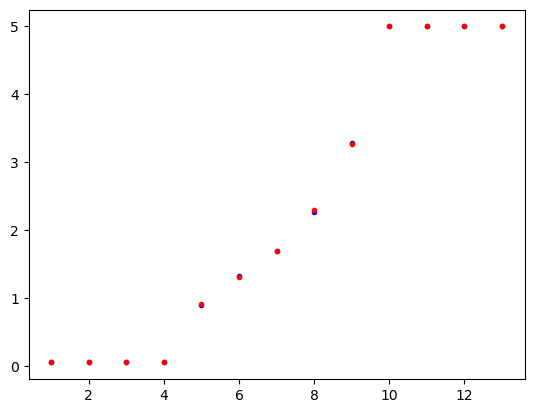

In [33]:
figure()
for n in 1:2
    plotWithError(T[n,idx], 1:length(idx), colors[n], TStd[n,idx])
end
savefig("figs/Demon_Bath_Temperatures.png")

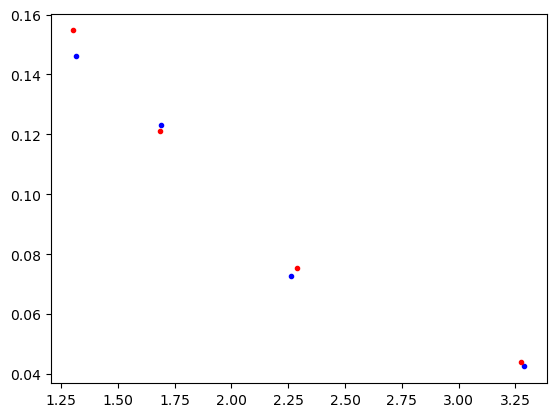

In [34]:
figure()
for n in 1:2
    plotWithError(κ[n,idx], T[n,idx], colors[n], κStd[n,idx], TStd[n,idx])
end
ylim([0, 0.3])
savefig("figs/Demon_Bath_Conductivity.png")

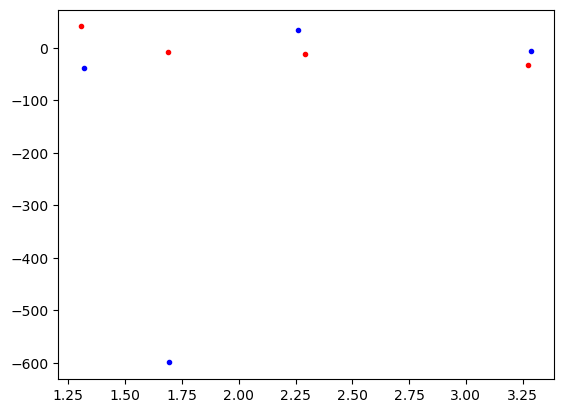

In [35]:
figure()
for n in 1:2
    plotWithError(C[n,idx], T[n,idx], colors[n], CStd[n,idx], TStd[n,idx])
end
savefig("figs/Demon_Bath_Capacity.png")

In [36]:
T = Nothing
κ = Nothing

Nothing

In [37]:
t1 = now()
print("\n", canonicalize(t1 - t0))


27 seconds, 654 milliseconds

## Green-Kubo Method

### Demon Dynamics

In [38]:
@everywhere include(dir * "/functions/simulationFunctions/DemonKubo.jl")

In [43]:
#global testing = []

# PARAMETERS
L = [25, 25]
PBC = [true, true]
Basis = CubicBasis(length(L))

# find minimal representable temperature (just done for 𝒽=0 for now - MAYBE MODIFY TO PICK MAX OVER DIFF FIELDS??
Nmin = (T,h) -> (sixVertex ? 2/(4*exp(-4/T)/3+h*exp(-2*h/T)) : 2/(exp(-2/T)+2*h*exp(-2*h/T))) # minimal lattice size on which T=Tmin is possible - see https://www.desmos.com/calculator/ll1ljvjmcg for details
Tmin = find_zero((T) -> prod(L)-Nmin(T,0), 0.3)
Tmax = 10.0 * (sixVertex ? 1.0 : 0.5)
NumT = 50
T = collect(range(Tmin, Tmax, length=NumT)) # the +0.1 is a fudge factor to fix our approximations earlier... (exact value doesn't matter b/c just adds ~a single demon)

num_histories = 1
runtime = 10000
t_cutoff = 100
t_therm = 5000
t_autocorr = 100
N_blocks = -1

# EVALUATION
Tobs, κ, C, Diff, TobsStd, κStd, CStd, DiffStd = DKuboSimulation(L, PBC, Basis, num_histories, runtime, t_therm, t_autocorr, N_blocks, t_cutoff, T);

In [45]:
now()

2023-04-15T11:03:40.860

In [46]:
colors = jetmap(1)

1-element Vector{Tuple{Float64, Float64, Float64}}:
 (0.0, 0.0, 0.498)

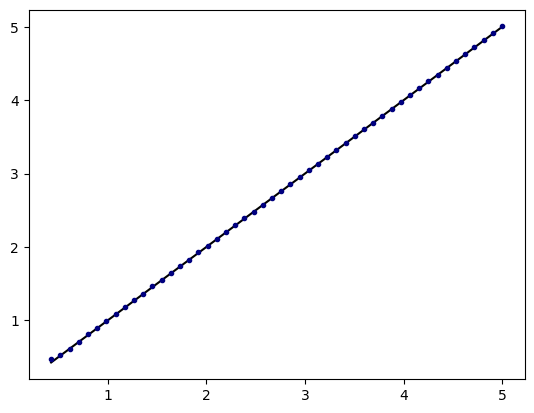

In [47]:
figure()
#plot(T, T, color=:black)
for n in 1:size(Tobs, 2)
    plotWithError(Tobs, T, colors[1], TobsStd)
end
# Just to check that out temperature estimates aren't too far off

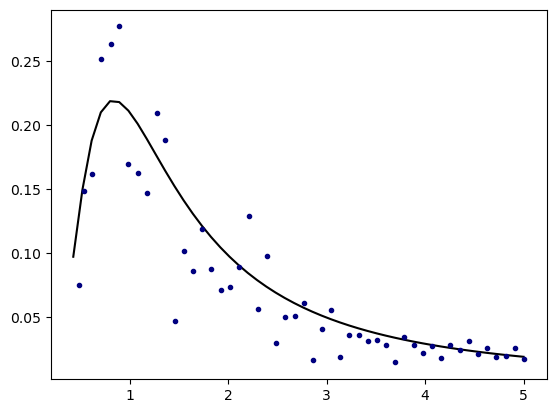

In [48]:
figure()
#plot(T, ((1 .- tanh.(1 ./T)) ./ T.^2) .* 0.5.*(1 .+ tanh.(1 ./T)), color=:black)
for n in 1:size(Tobs, 2)
    plotWithError(κ, Tobs, colors[1], κStd, TobsStd)
end
ylim([0, 0.3])
savefig("figs/Demon_Kubo_Conductivity.png")

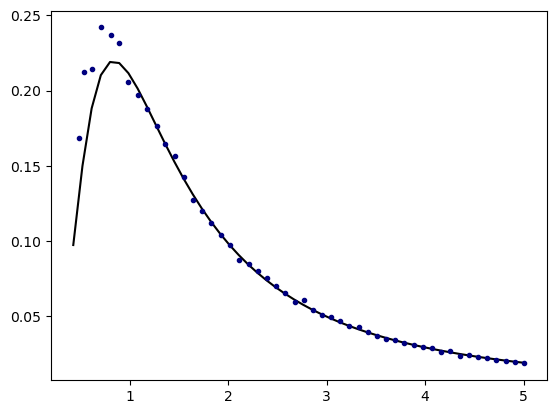

In [49]:
figure()
#plot(T, 0.5 ./ T.^2 ./ cosh.(1 ./T).^2, color=:black)
plotWithError(C, Tobs, colors[1], CStd, TobsStd)
ylim([0, 0.3])
savefig("figs/Demon_Kubo_Capacity.png")

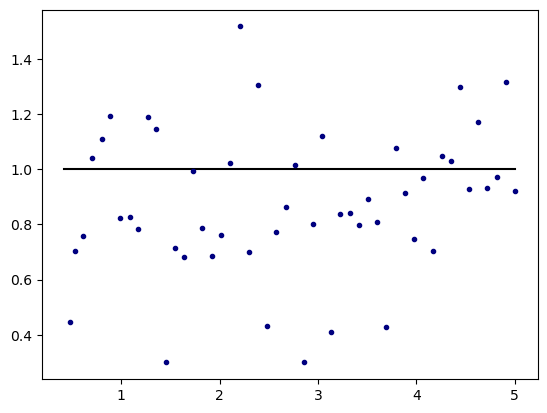

In [50]:
figure()
#plot(T, ones(size(T)), color=:black)
plotWithError(Diff, Tobs, colors[1], DiffStd, TobsStd)
ylim([0, 2.0])
savefig("figs/Demon_Kubo_Diff.png")

In [51]:
κ = Nothing
C_σ = Nothing
κStd = Nothing 
C_σStd = Nothing

Nothing

In [52]:
t2 = now()
print(canonicalize(t2 - t1))

1 minute, 12 seconds, 258 milliseconds

### Microcanonical Dynamics

In [53]:
@everywhere include(dir * "/functions/simulationFunctions/MicroKubo.jl")

In [60]:
# PARAMETERS
L = [25, 25]
PBC = [true, true]
Basis = CubicBasis(length(L))

Tmin = 0.01
Tmax = 10.0
NumT = 50

#Tmax *= (sixVertex ? 1.0 : 0.5)
T = range(Tmin, Tmax, length=NumT)

𝒽 = [0] #range(0, 1, length=7)

num_histories = 1
therm_runtime = 10000
runtime = 10000
t_therm = 5000
t_autocorr = 100
N_blocks = -1
t_cutoff = 100


# EVALUATION
κ, C, Diff, M, ℙ, κStd, CStd, DiffStd, MStd, ℙStd = MKuboSimulation(L, PBC, Basis, num_histories, runtime, therm_runtime, t_therm, t_autocorr, N_blocks, t_cutoff, T, 𝒽);

In [61]:
#for t in testing
#    scatter(t[1], t[3], color=:black) # t[2]=h=0 for now
#end

In [62]:
now()

2023-04-15T11:11:02.656

In [1]:
colors = jetmap(size(κ, 2));

LoadError: UndefVarError: κ not defined

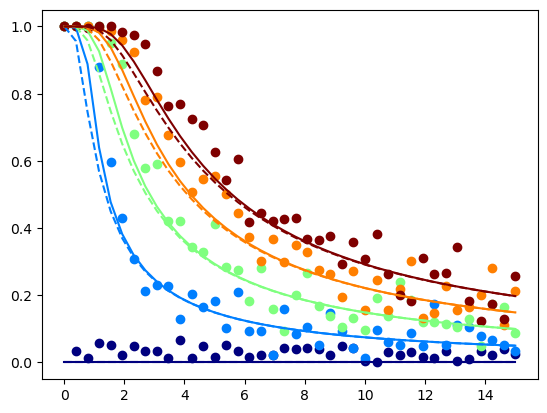

In [64]:
figure()
Tfun = (M, h) -> (h .+ 0.5 .* M .^ 3) ./ atanh.(M)
function Mfun(T, h)
    m = zeros(length(T))
    
    if h==0
        return m
    end
    
    for i in eachindex(T)
        m[i] = find_zero((M) -> Tfun(M, h) - T[i], (0, 1))
    end
    return m
end

Mfun0 = (T, h) -> tanh.(h ./ T)

for n in 1:size(κ, 2)
    #plot(T, Mfun0(T, 𝒽[n]), color=colors[n], "--")
    #plot(T, Mfun(T, 𝒽[n]), color=colors[n])
    scatter(T, M[:,n], color=colors[n])
end
savefig("figs/Micro_Kubo_Magnetisation.png")

In [ ]:
figure()
#ℙfunMF = (T, h) -> (1 .- Mfun0(T, h) .^2) ./ 3
ℙfunLim = (T, h) -> (1 .- Mfun0(T, h) .^2) ./ 4

for n in 1:size(κ, 2)
    #plot(T, ℙfunMF(T, 𝒽[n]), color=colors[n], "--")
    #plot(T, ℙfunLim(T, 𝒽[n]), color=colors[n])
    scatter(T, ℙ[:,n], color=colors[n])
end
savefig("figs/Micro_Kubo_Percolation.png")

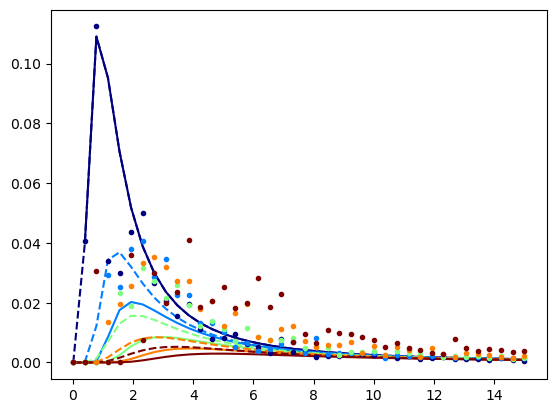

In [82]:
figure()
nfun0 = (T) -> 0.5 .* (1 .- tanh.(1 ./ T))
nfun = (T, h) -> 1 ./ (1 .+ exp.(2 ./ T) .* exp.(h ./ T ./ sqrt.(nfun0(T))))
Kfun = (T, h) -> (2 .* nfun(T, h) ./ T.^2) .* (1 .- nfun(T, h)) .* (1 .- Mfun(T, h)) ./ 2 # additional magnetisation factor for +-+- bond percolation
Kfun0 = (T, h) -> (2 .* nfun0(T) ./ T.^2) .* (1 .- nfun0(T)) .* (1 .- Mfun(T, h)) ./ 2

for n in 1:size(κ, 2)
    #plot(T, Kfun(T, 𝒽[n]), color=colors[n], "--")
    #plot(T, Kfun0(T, 𝒽[n]), color=colors[n])
    plotWithError(κ[:,n], T, colors[n], κStd[:,n])
end
ylim([0, 0.3])
savefig("figs/Micro_Kubo_Conductivity.png")

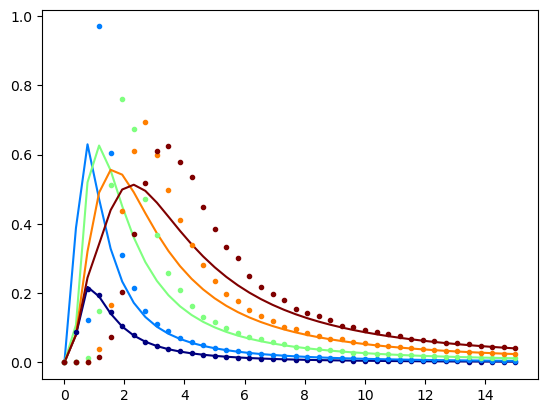

In [76]:
figure()
Cfun = (T, h) -> (sech.(1 ./T).^2 + 2 * h^2 .* sech.(h ./T).^2) ./ 2 ./ T.^2
for n in 1:size(κ, 2)
    #plot(T, Cfun(T, 𝒽[n]), color=colors[n])
    plotWithError(C[:,n], T, colors[n], CStd[:,n])
end
ylim([0, 0.3])
savefig("figs/Micro_Kubo_Capacity.png")

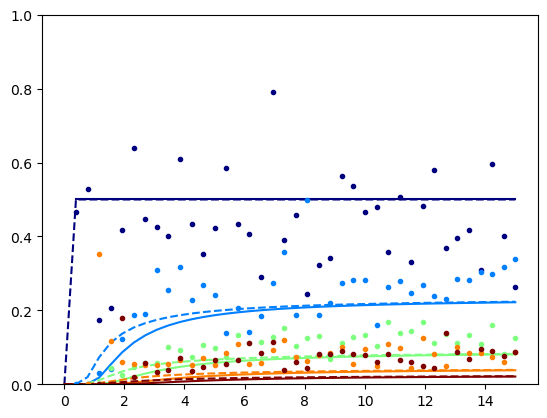

(0.0, 1.0)

In [83]:
figure()
Dfun = (T, h) -> Kfun(T, h) ./ Cfun(T, h)
Dfun0  = (T, h) -> Kfun0(T, h) ./ Cfun(T, h)
for n in 1:size(κ, 2)
    #plot(T, Dfun(T, 𝒽[n]), color=colors[n], "--")
    #plot(T, Dfun0(T, 𝒽[n]), color=colors[n])
    plotWithError(Diff[:,n], T, colors[n], DiffStd[:,n])
end
savefig("figs/Micro_Kubo_Diff.png")
ylim([0, 2.0])

In [68]:
κ = Nothing
C_σ = Nothing
κStd = Nothing 
C_σStd = Nothing

Nothing

In [69]:
t3 = now()
print("\n", canonicalize(t3 - t2))


1 minute, 41 seconds, 394 milliseconds

### Diffusive Motion

In [77]:
@everywhere include(dir * "/functions/simulationFunctions/MicroDiffusion.jl")

In [117]:
L = [25, 25]
PBC = [true, true]
Basis = CubicBasis(length(L))

therm_runtime = 1000
runtime = 1000
tau = 2:floor(Int64, 0.75*runtime)
num_histories = 50
𝒽 = [0.0] #range(0.0, 2.0, length=7)

T = []; range(0.01, 10.0, length=20);
ℓ = [1, 1]; # floor.(Int64, range(1, prod(L)/4, length=20));


x, δ, Mag, Perc, p, Nv = DiffSim(L, PBC, Basis, therm_runtime, runtime, ℓ, T, 𝒽)
D, α, C, γ, MSD, StepCorr = DiffAnalysis(x, δ, p, runtime, ℓ, T, 𝒽)

In [ ]:
colors = jetmap(length(𝒽))

In [ ]:
Mag = mean(Mag, dims=3)

figure()
for i in eachindex(𝒽)
    if length(T) > 0
        scatter(T, Mag[:,i], color=colors[i])
        #plot(T, Mfun(T, 𝒽[i]), color=colors[i])
    elseif length(ℓ) > 0
        scatter(ℓ, Mag[:,i], color=colors[i])
    end
end
savefig("figs/Magnetisation.png")

In [ ]:
Perc = mean(Perc, dims=3)

figure()
for i in eachindex(𝒽)
    if length(T) > 0
        scatter(T, Perc[:,i], color=colors[i])
    elseif length(ℓ) > 0
        scatter(ℓ, Perc[:,i], color=colors[i])
    end
end

savefig("figs/Percolation.png")

In [85]:
figure()
for t in size(MSD, 2)
    for i in size(MSD, 3)
        if MSD[:,t,i] != [NaN for _ in 1:size(MSD, 1)]
            loglog(MSD[:,t,i], color=colors[i])
            plot(MSD[:,t,i], color=colors[i])
        end
    end
end
#legend(loc = "upper right", bbox_to_anchor = (1.25, 1.0))
savefig("figs/MSD.png")

LoadError: UndefVarError: tmp1 not defined

In [86]:
# step direction autocorrelation
figure()
for t in size(StepCorr, 2)
    for i in size(StepCorr, 3)
        if StepCorr[:,t,i] != [NaN for _ in 1:size(StepCorr, 1)]
            #loglog(abs.(StepCorr[:,t,i]), color=colors[i])
            plot(StepCorr[:,t,i], color=colors[i])
        end
    end
end
savefig("figs/StepCorr.png")

LoadError: UndefVarError: tmp1 not defined

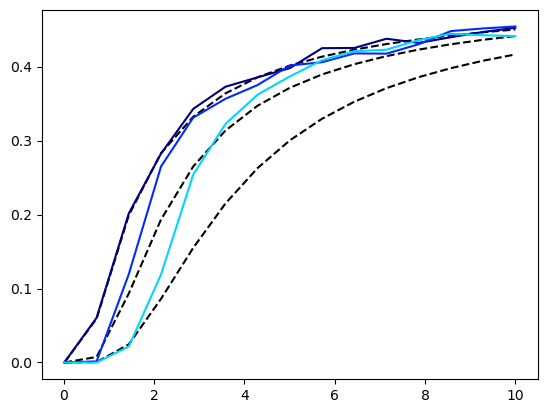

In [127]:
# estimate based on assuming the number of particles is <ϵ_i>/2λ/2 in single vertex approxn

figure() # density of quasiparticles
p = mean(p, dims=3) ./ Nv

if length(T) > 0
    nfun0 = (T) -> (1 .- tanh.(1 ./ T)) ./ 2
    Mfun0 = (T, h) -> tanh.(h ./ T)
    nfun = (T, h) -> nfun0(T .* (1 .- h .* Mfun0(T, h) ./ 2)) # 
    nfun2 = (T, h) -> nfun0(T ./ (1 .+ h .* Mfun0(T, h) ./ 2))
    
    for i in eachindex(𝒽)
        plot(T, p[:,i], color=colors[i])
        #plot(T, nfun(T, 𝒽[i]), color=colors[i], "--")
        #plot(T, nfun2(T, 𝒽[i]), color=colors[i], "--")
    end
elseif length(ℓ) > 0
    pExp = 2 .* ℓ ./ Nv
    
    for i in eachindex(𝒽)
        scatter(ℓ, p[:,i], color=colors[i])
    end
    plot(ℓ, pExp, color=:black, "--")
end
savefig("figs/Quasiparticle Number.png")

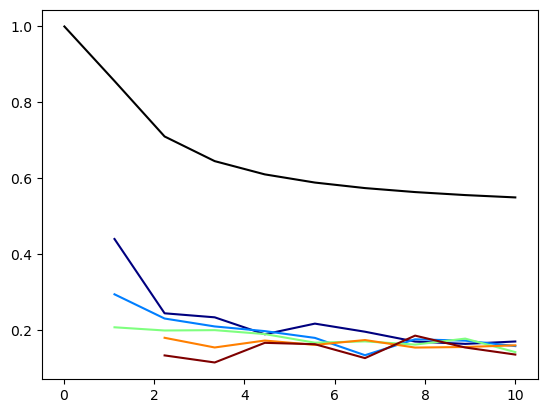

In [256]:
figure() # diffusion coefficient
nfun0 = (T) -> (1 .- tanh.(1 ./ T)) ./ 2
#nfun  = (T, h) -> 1 ./ (1 .+ exp.(2 ./ T) .* exp.(h ./ T ./ sqrt.(nfun0(T))))
#Dfun  = (T, h) -> (1 .- nfun(T, h)) .* (1 .- Mfun(T, h)) ./ 2
DfunPlus = (T, h) -> (1 .- nfun0(T)) .* (1 .+ Mfun(T, h)) ./ 2
DfunMinus = (T, h) -> (1 .- nfun0(T)) .* (1 .- Mfun(T, h)) ./ 2

#nfun = (T) -> sixVertex ? 4 .* (exp.(-4 ./ T) .+ exp.(-16 ./ T)) ./ (3 .+ 4 .* exp.(-4 ./ T) .+ exp.(-16 ./ T)) : 0.5 .* (1 .- tanh.(1 ./ T))
#Dfun = (n) -> sixVertex ? 7/12 .* (1 .- n) : 1 .* (1 .- n)

if length(T) > 0
    for i in eachindex(𝒽)
        plotWithError(D[1,:,i], T, colors[i], D[2,:,i])
        #plot(T, DfunPlus(T, 𝒽[i]), color=colors[i])
        #plot(T, DfunMinus(T, 𝒽[i]), color=colors[i], "--")
    end
elseif length(ℓ) > 0
    #plot(ℓ, Dfun(2 .* ℓ ./ Nv), color=:black)
    for i in eachindex(𝒽)
        plotWithError(D[1,:,i], ℓ, colors[i], D[2,:,i])
    end
end
savefig("figs/Diffusion Coefficient.png")

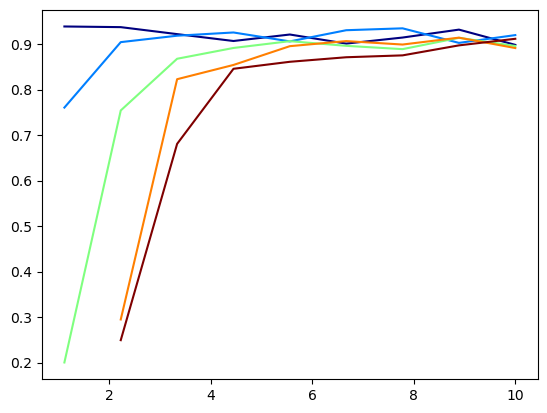

In [257]:
figure() # diffusion exponent
if length(T) > 1
    for i in eachindex(𝒽)
        plotWithError(α[1,:,i], T, colors[i], α[2,:,i])
    end
elseif length(ℓ) > 0
    for i in eachindex(𝒽)
        plotWithError(α[1,:,i], ℓ, colors[i], α[2,:,i])
    end
end
savefig("figs/Diffusion Exponent.png")

In [222]:
t4 = now()
print("\n", canonicalize(t4 - t3))


30 minutes, 45 seconds, 891 milliseconds

In [223]:
print("\nTOTAL RUNTIME = ", canonicalize(t4 - t0))


TOTAL RUNTIME = 34 minutes, 11 seconds, 62 milliseconds